In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt
import numpy as np


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


In [2]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

#y_old = df[[OLD_VAR]].values.flatten().astype(float)
#y_test_old = y[-ntest:]

In [4]:
SEED = 98
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [35]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


# Cuffed model

In [11]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [12]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.5;, score=0.877 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=1;, score=0.878 total time=   0.4s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.881 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.880 total time=   2.2s
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.883 total time=   2.9s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=1;, score=0.880 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=1;, score=0.874 total time=   1.3s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, 

In [14]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-cuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Uncuffed model

In [15]:
train_mask = (x_train[:,4] == 0)
test_mask = (x_test[:,4] == 0)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [16]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.877 total time=   2.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.875 total time=   2.9s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=0.8;, score=0.882 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=0.5;, score=0.873 total time=   1.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=1;, score=0.866 total time=   4.9s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=75, subsample=0.5;, score=0.885 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, max_depth

In [17]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-uncuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Cuffed + Uncuffed

## Age-based (Cole)

In [8]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.272
mean_absolute_errors: 0.395
r2_score: 0.725
acc: 0.344
acc(+-0.5mm): 0.878


## XGBR

In [9]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=50, subsample=0.5;, score=0.881 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=0.8;, score=0.877 total time=   2.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.8;, score=0.881 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=50, subsample=1;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=5, n_estimators=100, subsample=0.5;, score=0.875 total time=   2.3s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.5s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=1;, score=0.873 total time=   2.1s
[CV 2/5] END colsample_bytree=0.8, max_

In [10]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

## RF

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 5, 7],#[3,4,5],
                'max_leaf_nodes': [3, 5, 7],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                #'min_samples_split': [2,3,5],
                #'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 4/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=3, n_estimators=300;, score=0.734 total time=   5.0s
[CV 6/10] END bootstrap=True, max_depth=3, max_features=auto, max_leaf_nodes=7, n_estimators=100;, score=0.837 total time=   2.0s
[CV 3/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=50;, score=0.735 total time=   0.5s
[CV 1/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=100;, score=0.744 total time=   0.9s
[CV 10/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=100;, score=0.752 total time=   1.3s
[CV 4/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=300;, score=0.754 total time=   4.2s
[CV 1/10] END bootstrap=True, max_depth=3, max_features=sqrt, max_leaf_nodes=7, n_estimators=300;, score=0.839 total time=   3.4s
[CV 8/10] END bootstrap=T

In [32]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.872 total time=   6.7s
[CV 10/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50;, score=0.870 total time=   5.1s
[CV 9/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.873 total time=  19.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.874 total time=  30.3s
[CV 8/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.873 total time=  20.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=0.875 total time=   5.0s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estim

In [33]:
print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_RF_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

--------------
new model
--------------
explained_variance_score: 0.860
mean_squared_errors: 0.139
mean_absolute_errors: 0.224
r2_score: 0.860
acc: 0.595
acc(+-0.5mm): 0.963


## DNN

In [1]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [2]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
#y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df.loc[:ntrain-1,INPUT_VARS])
x_test = sc.transform(df.loc[ntrain:,INPUT_VARS])

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [5]:
# folder
nfold = 10  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"result/size/DNN_size_both_y"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: DNN 2 layers, regression')
f.write(f'input: age, sex, height, weight, cuffed 유무  output: tube size')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters pool
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [16, 32, 64, 128, 256, 512]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)


for dnode1 in dense_opts:
    for dropout1 in dropout_opts:
        for dnode2 in dense_opts:
            for dropout2 in dropout_opts:
                for batch_size in BATCH_SIZE:
                    for learning_rate in lr_opts:
                        test_settings.append([dnode1, dropout1, dnode2, dropout2, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-02-18 10:59:01.424856


In [ ]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    nlayer = random.choice([1,2]) 
    # test settings
    dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(nlayer):
        odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
    odir_f += f'lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)


    # build a model
    inp = Input(shape=(x_train.shape[1],))
    out = inp

    
    for i in range(nlayer):      
        out = Dense(dnodes[i], activation='relu')(out)
        out = Dropout(dropouts[i])(out)
    
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    acc1s, acc3s, maes = [], [], []

    switch = 0
    for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
        X_train = x_train_imputed[train_mask]
        X_test = x_train_imputed[test_mask] 
        
        Y_train = y_train[train_mask] 
        Y_test = y_train[test_mask]


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
            hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten() 
            y_pred = np.round(y_pred * 2) / 2
            
            acc1 = np.mean(y_pred==Y_test)
            acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
            mae = mean_absolute_error(Y_test, y_pred)           
            
            acc1s.append(acc1)
            acc3s.append(acc3)
            maes.append(mae)

            print(f' ###{fold} fold : val acc1 {acc1:.3f}, acc3 {acc3:.3f}, mae {mae:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue
    

    print(f'acc1{np.mean(acc1s):.3f}_acc3{np.mean(acc3s):.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/acc1-{np.mean(acc1s):.3f}_acc3-{np.mean(acc3s):.3f}_{odir_f}')
    tf.keras.backend.clear_session()

random search 0/500


2023-02-18 10:59:03.711163: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 10:59:04.435367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
609/613 [============================>.] - ETA: 0s - loss: 0.9278
Epoch 00001: val_loss improved from inf to 0.19348, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 4s 4ms/step - loss: 0.9244 - val_loss: 0.1935
Epoch 2/100
605/613 [============================>.] - ETA: 0s - loss: 0.2676
Epoch 00002: val_loss improved from 0.19348 to 0.13977, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2676 - val_loss: 0.1398
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.2599
Epoch 00003: val_loss did not improve from 0.13977
613/613 [==============================] - 2s 4ms/step - loss: 0.2595 - val_loss: 0.1916
Epoch 4/100
605/613 [============================>.] - ETA: 0s - loss: 0.2632
Epoch 00004: val_loss improv

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 0.8756
Epoch 00001: val_loss improved from inf to 0.20557, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8750 - val_loss: 0.2056
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.2763
Epoch 00002: val_loss improved from 0.20557 to 0.13710, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2759 - val_loss: 0.1371
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.2791
Epoch 00003: val_loss did not improve from 0.13710
613/613 [==============================] - 2s 4ms/step - loss: 0.2789 - val_loss: 0.2821
Epoch 4/100
606/613 [============================>.] - ETA: 0s - loss: 0.2498
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 0.8660
Epoch 00001: val_loss improved from inf to 0.20387, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8660 - val_loss: 0.2039
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.2742
Epoch 00002: val_loss improved from 0.20387 to 0.14028, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2740 - val_loss: 0.1403
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.2838
Epoch 00003: val_loss did not improve from 0.14028
613/613 [==============================] - 2s 4ms/step - loss: 0.2842 - val_loss: 0.3150
Epoch 4/100
611/613 [============================>.] - ETA: 0s - loss: 0.2604
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 0.8958
Epoch 00001: val_loss improved from inf to 0.18587, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8830 - val_loss: 0.1859
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.2737
Epoch 00002: val_loss improved from 0.18587 to 0.14256, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2729 - val_loss: 0.1426
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.3089
Epoch 00003: val_loss did not improve from 0.14256
613/613 [==============================] - 2s 3ms/step - loss: 0.3089 - val_loss: 0.2841
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.2555
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 0.9150
Epoch 00001: val_loss improved from inf to 0.17072, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9150 - val_loss: 0.1707
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.2974
Epoch 00002: val_loss improved from 0.17072 to 0.15626, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2973 - val_loss: 0.1563
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.3098
Epoch 00003: val_loss improved from 0.15626 to 0.15126, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3090 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 0.5446
Epoch 00001: val_loss improved from inf to 0.20312, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.5436 - val_loss: 0.2031
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.2506
Epoch 00002: val_loss improved from 0.20312 to 0.17047, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2505 - val_loss: 0.1705
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.2181
Epoch 00003: val_loss improved from 0.17047 to 0.14858, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2179 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


609/613 [============================>.] - ETA: 0s - loss: 1.1688
Epoch 00001: val_loss improved from inf to 0.14863, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1633 - val_loss: 0.1486
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.2978
Epoch 00002: val_loss did not improve from 0.14863
613/613 [==============================] - 2s 4ms/step - loss: 0.2978 - val_loss: 0.1860
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.2587
Epoch 00003: val_loss improved from 0.14863 to 0.14522, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2577 - val_loss: 0.1452
Epoch 4/100
612/613 [============================>.] - ETA: 0s - loss: 0.2847
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 1.1516
Epoch 00001: val_loss improved from inf to 0.15978, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1346 - val_loss: 0.1598
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.3361
Epoch 00002: val_loss did not improve from 0.15978
613/613 [==============================] - 2s 4ms/step - loss: 0.3354 - val_loss: 0.1656
Epoch 3/100
601/613 [============================>.] - ETA: 0s - loss: 0.3062
Epoch 00003: val_loss improved from 0.15978 to 0.14360, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3046 - val_loss: 0.1436
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.3030
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 1.1416
Epoch 00001: val_loss improved from inf to 0.15102, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1416 - val_loss: 0.1510
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.3356
Epoch 00002: val_loss did not improve from 0.15102
613/613 [==============================] - 2s 4ms/step - loss: 0.3348 - val_loss: 0.1543
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.3109
Epoch 00003: val_loss improved from 0.15102 to 0.14850, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3098 - val_loss: 0.1485
Epoch 4/100
607/613 [============================>.] - ETA: 0s - loss: 0.3055
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 1.1428
Epoch 00001: val_loss improved from inf to 0.14796, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1416 - val_loss: 0.1480
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.3350
Epoch 00002: val_loss did not improve from 0.14796
613/613 [==============================] - 2s 4ms/step - loss: 0.3348 - val_loss: 0.1540
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.3098
Epoch 00003: val_loss improved from 0.14796 to 0.14688, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3098 - val_loss: 0.1469
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.3061
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 19.2984
Epoch 00001: val_loss improved from inf to 13.59509, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5708 - val_loss: 13.5951
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 10.5923
Epoch 00002: val_loss improved from 13.59509 to 6.51969, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0363 - val_loss: 6.5197
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 4.8782
Epoch 00003: val_loss improved from 6.51969 to 2.76211, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.7532 - val_loss: 2.7621
Epoch 4/100
62/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 18.9252
Epoch 00001: val_loss improved from inf to 13.58276, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 18.5561 - val_loss: 13.5828
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.3997
Epoch 00002: val_loss improved from 13.58276 to 6.51094, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0374 - val_loss: 6.5109
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 4.8014
Epoch 00003: val_loss improved from 6.51094 to 2.75632, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7617 - val_loss: 2.7563
Epoch 4/100
64/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
66/77 [========================>.....] - ETA: 0s - loss: 19.2794
Epoch 00001: val_loss improved from inf to 13.57704, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5766 - val_loss: 13.5770
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 10.4306
Epoch 00002: val_loss improved from 13.57704 to 6.51213, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0256 - val_loss: 6.5121
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.8058
Epoch 00003: val_loss improved from 6.51213 to 2.75964, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7449 - val_loss: 2.7596
Epoch 4/100
65/77 [========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.2071
Epoch 00001: val_loss improved from inf to 13.59920, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5740 - val_loss: 13.5992
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 10.2361
Epoch 00002: val_loss improved from 13.59920 to 6.52496, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0392 - val_loss: 6.5250
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.8193
Epoch 00003: val_loss improved from 6.52496 to 2.76727, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7580 - val_loss: 2.7673
Epoch 4/100
64/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 19.1370
Epoch 00001: val_loss improved from inf to 13.62650, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5864 - val_loss: 13.6265
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.5958
Epoch 00002: val_loss improved from 13.62650 to 6.56603, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.1806 - val_loss: 6.5660
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 5.3245
Epoch 00003: val_loss improved from 6.56603 to 2.93432, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.0215 - val_loss: 2.9343
Epoch 4/100
59/77 [=====================>........] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 19.0090
Epoch 00001: val_loss improved from inf to 13.47621, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5166 - val_loss: 13.4762
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1652
Epoch 00002: val_loss improved from 13.47621 to 6.26303, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.7668 - val_loss: 6.2630
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 4.6294
Epoch 00003: val_loss improved from 6.26303 to 2.72390, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.4389 - val_loss: 2.7239
Epoch 4/100
64/77 [=======================>......] - ETA: 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/77 [======================>.......] - ETA: 0s - loss: 19.5526
Epoch 00001: val_loss improved from inf to 13.48230, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 18.5092 - val_loss: 13.4823
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 10.4086
Epoch 00002: val_loss improved from 13.48230 to 6.32192, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9932 - val_loss: 6.3219
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 5.2128
Epoch 00003: val_loss improved from 6.32192 to 2.90692, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.8909 - val_loss: 2.9069
Epoch 4/100
75/77 [============================>.] - ETA: 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.1366
Epoch 00001: val_loss improved from inf to 13.50595, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5085 - val_loss: 13.5059
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1419
Epoch 00002: val_loss improved from 13.50595 to 6.32988, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0093 - val_loss: 6.3299
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 5.0922
Epoch 00003: val_loss improved from 6.32988 to 2.90187, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8839 - val_loss: 2.9019
Epoch 4/100
67/77 [=========================>....] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 19.0711
Epoch 00001: val_loss improved from inf to 13.57709, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5040 - val_loss: 13.5771
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 10.0093
Epoch 00002: val_loss improved from 13.57709 to 6.39765, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0119 - val_loss: 6.3977
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 5.1391
Epoch 00003: val_loss improved from 6.39765 to 2.94436, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8849 - val_loss: 2.9444
Epoch 4/100
61/77 [======================>.......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.1441
Epoch 00001: val_loss improved from inf to 13.59553, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5040 - val_loss: 13.5955
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1395
Epoch 00002: val_loss improved from 13.59553 to 6.39376, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0119 - val_loss: 6.3938
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 5.1391
Epoch 00003: val_loss improved from 6.39376 to 2.94915, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8849 - val_loss: 2.9491
Epoch 4/100
67/77 [=========================>....] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 2.3059
Epoch 00001: val_loss improved from inf to 0.29873, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2248 - val_loss: 0.2987
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.6961
Epoch 00002: val_loss improved from 0.29873 to 0.23571, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6914 - val_loss: 0.2357
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.4471
Epoch 00003: val_loss did not improve from 0.23571
307/307 [==============================] - 1s 4ms/step - loss: 0.4472 - val_loss: 0.4649
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.3459
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.2612
Epoch 00001: val_loss improved from inf to 0.30472, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2171 - val_loss: 0.3047
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.6851
Epoch 00002: val_loss improved from 0.30472 to 0.23432, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6849 - val_loss: 0.2343
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.3296
Epoch 00003: val_loss did not improve from 0.23432
307/307 [==============================] - 1s 4ms/step - loss: 0.4460 - val_loss: 0.5423
Epoch 4/100
300/307 [============================>.] - ETA: 0s - loss: 0.3456
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 2.2622
Epoch 00001: val_loss improved from inf to 0.31248, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2246 - val_loss: 0.3125
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.6889
Epoch 00002: val_loss improved from 0.31248 to 0.24899, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6779 - val_loss: 0.2490
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.4442
Epoch 00003: val_loss did not improve from 0.24899
307/307 [==============================] - 1s 4ms/step - loss: 0.4442 - val_loss: 0.5783
Epoch 4/100
305/307 [============================>.] - ETA: 0s - loss: 0.3529
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 2.3247
Epoch 00001: val_loss improved from inf to 0.32342, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2558 - val_loss: 0.3234
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.7023
Epoch 00002: val_loss improved from 0.32342 to 0.25477, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6931 - val_loss: 0.2548
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.4390
Epoch 00003: val_loss did not improve from 0.25477
307/307 [==============================] - 1s 4ms/step - loss: 0.4393 - val_loss: 0.5460
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.3419
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.5994
Epoch 00001: val_loss improved from inf to 0.28460, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.5610 - val_loss: 0.2846
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.7323
Epoch 00002: val_loss did not improve from 0.28460
307/307 [==============================] - 1s 4ms/step - loss: 0.7323 - val_loss: 0.3070
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4214
Epoch 00003: val_loss improved from 0.28460 to 0.24682, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4171 - val_loss: 0.2468
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.3716
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 1.9631
Epoch 00001: val_loss improved from inf to 0.28280, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.9456 - val_loss: 0.2828
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.3715
Epoch 00002: val_loss did not improve from 0.28280
307/307 [==============================] - 1s 4ms/step - loss: 0.3712 - val_loss: 0.3349
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.3288
Epoch 00003: val_loss improved from 0.28280 to 0.25377, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3282 - val_loss: 0.2538
Epoch 4/100
302/307 [============================>.] - ETA: 0s - loss: 0.2938
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.8029
Epoch 00001: val_loss improved from inf to 0.28316, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6803 - val_loss: 0.2832
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.7779
Epoch 00002: val_loss improved from 0.28316 to 0.26019, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.7643 - val_loss: 0.2602
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.5137
Epoch 00003: val_loss improved from 0.26019 to 0.25654, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5083 - val_loss: 0.2565

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 3.7680
Epoch 00001: val_loss improved from inf to 0.29138, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6994 - val_loss: 0.2914
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.8563
Epoch 00002: val_loss improved from 0.29138 to 0.28048, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8563 - val_loss: 0.2805
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.5782
Epoch 00003: val_loss improved from 0.28048 to 0.26571, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5723 - val_loss: 0.2657

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 3.7854
Epoch 00001: val_loss improved from inf to 0.29486, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6849 - val_loss: 0.2949
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.8429
Epoch 00002: val_loss improved from 0.29486 to 0.27795, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8284 - val_loss: 0.2780
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.5581
Epoch 00003: val_loss improved from 0.27795 to 0.26602, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5537 - val_loss: 0.2660

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.8069
Epoch 00001: val_loss improved from inf to 0.29468, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6849 - val_loss: 0.2947
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.4014
Epoch 00002: val_loss improved from 0.29468 to 0.28426, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8284 - val_loss: 0.2843
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.5616
Epoch 00003: val_loss improved from 0.28426 to 0.27322, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5537 - val_loss: 0.2732

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.2906
Epoch 00001: val_loss improved from inf to 8.68182, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2502 - val_loss: 8.6818
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1274
Epoch 00002: val_loss improved from 8.68182 to 2.63956, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.1095 - val_loss: 2.6396
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7076
Epoch 00003: val_loss improved from 2.63956 to 1.23927, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0146 - val_loss: 1.2393
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.4575
Epoch 00001: val_loss improved from inf to 8.66922, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2572 - val_loss: 8.6692
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 7.2538
Epoch 00002: val_loss improved from 8.66922 to 2.63276, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1634 - val_loss: 2.6328
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 3.7019
Epoch 00003: val_loss improved from 2.63276 to 1.23048, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0018 - val_loss: 1.2305
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.3051
Epoch 00001: val_loss improved from inf to 8.66776, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2638 - val_loss: 8.6678
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1801
Epoch 00002: val_loss improved from 8.66776 to 2.65342, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1574 - val_loss: 2.6534
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 4.0358
Epoch 00003: val_loss improved from 2.65342 to 1.24771, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0316 - val_loss: 1.2477
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.3009
Epoch 00001: val_loss improved from inf to 8.68099, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2608 - val_loss: 8.6810
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1727
Epoch 00002: val_loss improved from 8.68099 to 2.66890, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1498 - val_loss: 2.6689
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7196
Epoch 00003: val_loss improved from 2.66890 to 1.24204, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0213 - val_loss: 1.2420
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.4773
Epoch 00001: val_loss improved from inf to 9.02238, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.4773 - val_loss: 9.0224
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 7.5799
Epoch 00002: val_loss improved from 9.02238 to 2.69405, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.4430 - val_loss: 2.6940
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 4.9056
Epoch 00003: val_loss improved from 2.69405 to 1.34364, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.9056 - val_loss: 1.3436
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 17.4852 
Epoch 00001: val_loss improved from inf to 8.38692, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 14.9323 - val_loss: 8.3869
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1308
Epoch 00002: val_loss improved from 8.38692 to 2.36527, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.1188 - val_loss: 2.3653
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 3.8135
Epoch 00003: val_loss improved from 2.36527 to 1.17219, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.5437 - val_loss: 1.1722
Epoch 4/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.0202
Epoch 00001: val_loss improved from inf to 8.56435, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0202 - val_loss: 8.5644
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1777
Epoch 00002: val_loss improved from 8.56435 to 2.41351, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5633 - val_loss: 2.4135
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 8.7343
Epoch 00003: val_loss improved from 2.41351 to 1.30823, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.2850 - val_loss: 1.3082
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 15.3584
Epoch 00001: val_loss improved from inf to 8.56687, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0224 - val_loss: 8.5669
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 6.5502
Epoch 00002: val_loss improved from 8.56687 to 2.39059, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5309 - val_loss: 2.3906
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 6.6024
Epoch 00003: val_loss improved from 2.39059 to 1.30556, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3910 - val_loss: 1.3056
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.2231
Epoch 00001: val_loss improved from inf to 8.64020, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0257 - val_loss: 8.6402
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 6.5444
Epoch 00002: val_loss improved from 8.64020 to 2.44355, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5444 - val_loss: 2.4435
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 6.3974
Epoch 00003: val_loss improved from 2.44355 to 1.35488, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3704 - val_loss: 1.3549
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.0257
Epoch 00001: val_loss improved from inf to 8.65024, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0257 - val_loss: 8.6502
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1395
Epoch 00002: val_loss improved from 8.65024 to 2.44073, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5444 - val_loss: 2.4407
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 6.3974
Epoch 00003: val_loss improved from 2.44073 to 1.34777, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3704 - val_loss: 1.3478
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


74/77 [===========================>..] - ETA: 0s - loss: 14.3561
Epoch 00001: val_loss improved from inf to 5.99854, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0817 - val_loss: 5.9985
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 3.4001
Epoch 00002: val_loss improved from 5.99854 to 1.28397, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1763 - val_loss: 1.2840
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.8492
Epoch 00003: val_loss improved from 1.28397 to 0.56727, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0933 - val_loss: 0.5673
Epoch 4/100
73/77 [===========================>..] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 15.4660
Epoch 00001: val_loss improved from inf to 5.99433, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.0777 - val_loss: 5.9943
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 3.5419
Epoch 00002: val_loss improved from 5.99433 to 1.28372, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.1940 - val_loss: 1.2837
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 0.8794
Epoch 00003: val_loss improved from 1.28372 to 0.56599, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1000 - val_loss: 0.5660
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 15.0138
Epoch 00001: val_loss improved from inf to 5.98259, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0752 - val_loss: 5.9826
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 3.4365
Epoch 00002: val_loss improved from 5.98259 to 1.28672, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1818 - val_loss: 1.2867
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 0.8984
Epoch 00003: val_loss improved from 1.28672 to 0.56612, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1002 - val_loss: 0.5661
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


72/77 [===========================>..] - ETA: 0s - loss: 14.5622
Epoch 00001: val_loss improved from inf to 6.00690, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0756 - val_loss: 6.0069
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 3.3128
Epoch 00002: val_loss improved from 6.00690 to 1.28855, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1968 - val_loss: 1.2886
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.8492
Epoch 00003: val_loss improved from 1.28855 to 0.56741, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0984 - val_loss: 0.5674
Epoch 4/100
77/77 [==============================] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 14.9715
Epoch 00001: val_loss improved from inf to 6.03597, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.0630 - val_loss: 6.0360
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 3.3954
Epoch 00002: val_loss improved from 6.03597 to 1.27325, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2180 - val_loss: 1.2732
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 1.1395
Epoch 00003: val_loss improved from 1.27325 to 0.55692, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0891 - val_loss: 0.5569
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 14.4306
Epoch 00001: val_loss improved from inf to 5.67252, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.8272 - val_loss: 5.6725
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 2.8557
Epoch 00002: val_loss improved from 5.67252 to 1.26020, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 2.7251 - val_loss: 1.2602
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 0.8391
Epoch 00003: val_loss improved from 1.26020 to 0.50660, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 0.8011 - val_loss: 0.5066
Epoch 4/100
76/77 [============================>.] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 14.9894
Epoch 00001: val_loss improved from inf to 5.80715, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9434 - val_loss: 5.8072
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 2.8885
Epoch 00002: val_loss improved from 5.80715 to 1.23732, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2112 - val_loss: 1.2373
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 1.2368
Epoch 00003: val_loss improved from 1.23732 to 0.54275, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1409 - val_loss: 0.5427
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 14.6647
Epoch 00001: val_loss improved from inf to 5.82032, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9567 - val_loss: 5.8203
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 2.9253
Epoch 00002: val_loss improved from 5.82032 to 1.24060, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2251 - val_loss: 1.2406
Epoch 3/100
69/77 [=========================>....] - ETA: 0s - loss: 1.2260
Epoch 00003: val_loss improved from 1.24060 to 0.55069, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1568 - val_loss: 0.5507
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 15.0105
Epoch 00001: val_loss improved from inf to 5.87894, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9575 - val_loss: 5.8789
Epoch 2/100
69/77 [=========================>....] - ETA: 0s - loss: 2.8599
Epoch 00002: val_loss improved from 5.87894 to 1.28191, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2275 - val_loss: 1.2819
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 1.2404
Epoch 00003: val_loss improved from 1.28191 to 0.56495, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1536 - val_loss: 0.5650
Epoch 4/100
70/77 [==========================>...] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


73/77 [===========================>..] - ETA: 0s - loss: 14.3478
Epoch 00001: val_loss improved from inf to 5.87727, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9575 - val_loss: 5.8773
Epoch 2/100
74/77 [===========================>..] - ETA: 0s - loss: 3.2966
Epoch 00002: val_loss improved from 5.87727 to 1.28024, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2275 - val_loss: 1.2802
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 1.1590
Epoch 00003: val_loss improved from 1.28024 to 0.55902, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1536 - val_loss: 0.5590
Epoch 4/100
71/77 [==========================>...] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 11.9084
Epoch 00001: val_loss improved from inf to 2.97762, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.5580 - val_loss: 2.9776
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.8272
Epoch 00002: val_loss improved from 2.97762 to 0.70460, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7474 - val_loss: 0.7046
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.4540
Epoch 00003: val_loss improved from 0.70460 to 0.32775, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6674 - val_loss: 0.3277
Epoch 4/100
150/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 11.6896
Epoch 00001: val_loss improved from inf to 2.96686, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5673 - val_loss: 2.9669
Epoch 2/100
134/154 [=========================>....] - ETA: 0s - loss: 1.9061
Epoch 00002: val_loss improved from 2.96686 to 0.70959, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7607 - val_loss: 0.7096
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4672
Epoch 00003: val_loss improved from 0.70959 to 0.33096, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.3310
Epoch 4/100
145/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 12.3405
Epoch 00001: val_loss improved from inf to 2.97901, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5602 - val_loss: 2.9790
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.7675
Epoch 00002: val_loss improved from 2.97901 to 0.71033, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7675 - val_loss: 0.7103
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.4660
Epoch 00003: val_loss improved from 0.71033 to 0.32990, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6834 - val_loss: 0.3299
Epoch 4/100
149/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 11.9167
Epoch 00001: val_loss improved from inf to 2.97873, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5652 - val_loss: 2.9787
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.7923
Epoch 00002: val_loss improved from 2.97873 to 0.70938, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7620 - val_loss: 0.7094
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 0.4715
Epoch 00003: val_loss improved from 0.70938 to 0.33052, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6793 - val_loss: 0.3305
Epoch 4/100
135/154 [=========================>....] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 11.7680
Epoch 00001: val_loss improved from inf to 2.98250, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.4724 - val_loss: 2.9825
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 1.7093
Epoch 00002: val_loss improved from 2.98250 to 0.69347, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.6949 - val_loss: 0.6935
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.6225
Epoch 00003: val_loss improved from 0.69347 to 0.31815, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6063 - val_loss: 0.3182
Epoch 4/100
153/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 11.6895
Epoch 00001: val_loss improved from inf to 2.74482, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.1650 - val_loss: 2.7448
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.3445
Epoch 00002: val_loss improved from 2.74482 to 0.63452, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.3435 - val_loss: 0.6345
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 0.4078
Epoch 00003: val_loss improved from 0.63452 to 0.28355, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.3932 - val_loss: 0.2836
Epoch 4/100
151/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 11.4712
Epoch 00001: val_loss improved from inf to 2.76609, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.2917 - val_loss: 2.7661
Epoch 2/100
136/154 [=========================>....] - ETA: 0s - loss: 1.4003
Epoch 00002: val_loss improved from 2.76609 to 0.63887, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5863 - val_loss: 0.6389
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.5693
Epoch 00003: val_loss improved from 0.63887 to 0.30019, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5523 - val_loss: 0.3002
Epoch 4/100
145/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 11.4255
Epoch 00001: val_loss improved from inf to 2.75367, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.3072 - val_loss: 2.7537
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.5957
Epoch 00002: val_loss improved from 2.75367 to 0.64698, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5957 - val_loss: 0.6470
Epoch 3/100
134/154 [=========================>....] - ETA: 0s - loss: 0.6108
Epoch 00003: val_loss improved from 0.64698 to 0.30390, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5711 - val_loss: 0.3039
Epoch 4/100
147/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 12.0341
Epoch 00001: val_loss improved from inf to 2.79849, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.3182 - val_loss: 2.7985
Epoch 2/100
137/154 [=========================>....] - ETA: 0s - loss: 1.3825
Epoch 00002: val_loss improved from 2.79849 to 0.65950, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5927 - val_loss: 0.6595
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.5743
Epoch 00003: val_loss improved from 0.65950 to 0.30077, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.5669 - val_loss: 0.3008
Epoch 4/100
152/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 12.0341
Epoch 00001: val_loss improved from inf to 2.80512, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.3182 - val_loss: 2.8051
Epoch 2/100
135/154 [=========================>....] - ETA: 0s - loss: 1.3933
Epoch 00002: val_loss improved from 2.80512 to 0.65927, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5927 - val_loss: 0.6593
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.5762
Epoch 00003: val_loss improved from 0.65927 to 0.29438, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5669 - val_loss: 0.2944
Epoch 4/100
149/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 14.5634
Epoch 00001: val_loss improved from inf to 5.77980, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8157 - val_loss: 5.7798
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 3.6397
Epoch 00002: val_loss improved from 5.77980 to 1.26724, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.5429 - val_loss: 1.2672
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.1079
Epoch 00003: val_loss improved from 1.26724 to 0.59965, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5213 - val_loss: 0.5996
Epoch 4/100
152/154 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/154 [=========================>....] - ETA: 0s - loss: 14.7270
Epoch 00001: val_loss improved from inf to 5.76695, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8072 - val_loss: 5.7669
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 3.5805
Epoch 00002: val_loss improved from 5.76695 to 1.25934, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.5517 - val_loss: 1.2593
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.1124
Epoch 00003: val_loss improved from 1.25934 to 0.59736, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5190 - val_loss: 0.5974
Epoch 4/100
142/154 [==========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 13.9890
Epoch 00001: val_loss improved from inf to 5.76621, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8219 - val_loss: 5.7662
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 3.6875
Epoch 00002: val_loss improved from 5.76621 to 1.27506, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.5617 - val_loss: 1.2751
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 1.1113
Epoch 00003: val_loss improved from 1.27506 to 0.60007, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5361 - val_loss: 0.6001
Epoch 4/100
148/154 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 14.3606
Epoch 00001: val_loss improved from inf to 5.78986, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8278 - val_loss: 5.7899
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 3.6070
Epoch 00002: val_loss improved from 5.78986 to 1.27671, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.5640 - val_loss: 1.2767
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 1.5363
Epoch 00003: val_loss improved from 1.27671 to 0.59709, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5314 - val_loss: 0.5971
Epoch 4/100
150/154 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/154 [=========================>....] - ETA: 0s - loss: 14.7932
Epoch 00001: val_loss improved from inf to 5.97838, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.9441 - val_loss: 5.9784
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 3.5351
Epoch 00002: val_loss improved from 5.97838 to 1.27437, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.4529 - val_loss: 1.2744
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.4300
Epoch 00003: val_loss improved from 1.27437 to 0.57980, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4011 - val_loss: 0.5798
Epoch 4/100
151/154 [============================>.

# age-based vs xgbr

In [36]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

y_pred = xgbr.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

# age-based formula 값 : y_test_old

# 두 공식 간에 다른값 비율
#y_pred == y_test_old

In [38]:
np.mean(y_pred == y_test_old)

0.3641304347826087

In [40]:
y_test_old

array([4.5, 5.5, 4. , ..., 4. , 5. , 4.5])

In [39]:
y_pred

array([5. , 6. , 4.5, ..., 4.5, 5. , 5. ], dtype=float32)

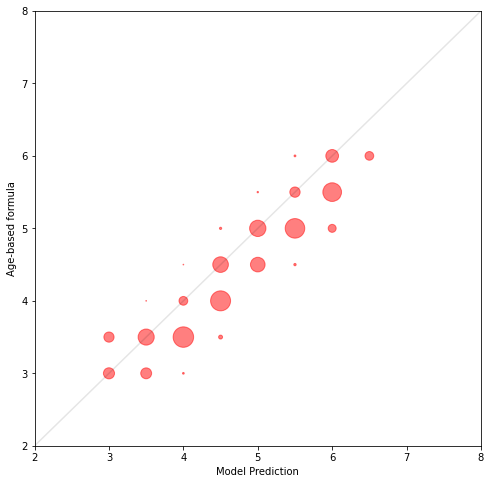

In [43]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((y_pred == x) & (y_test_old == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, legend=)
plt.xlabel('Model Prediction')
plt.ylabel('Age-based formula')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)

Text(0, 0.5, 'age-based formula')

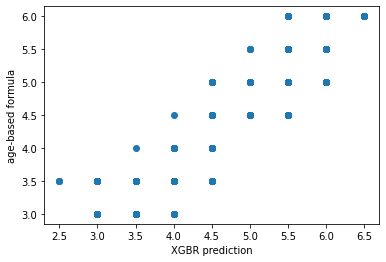

In [41]:
plt.scatter(y_pred, y_test_old)
plt.xlabel('XGBR prediction')
plt.ylabel('age-based formula')